# Training a CNN

Used this blog as a starting point:

http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/

# Lots of imports

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm     as cm
import matplotlib.image  as mpimg
%matplotlib inline  

from urllib import urlretrieve

import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Define our dataset loading function

The dataset is just a set of images stored in a shallow tree, with the directory signifying the class of the image. The images should all be normalized, using the code in the 'Image normalization' workbook.

In [43]:
def load_dataset(base_path):
    X            = []
    y            = []
    class_labels = {}
    
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            file_path  = os.path.join(subdir, file)
            image      = mpimg.imread(file_path)
            class_name = os.path.dirname(file_path).replace(base_path, '', 1)
            
            if not class_name in class_labels:
                class_labels[class_name] = len(class_labels)
                
            X.append(np.asarray(image))
            y.append(class_labels[class_name])
    
    class_labels_inverted = {v: k for k, v in class_labels.iteritems()}

    return np.array(X), np.array(y), class_labels_inverted

In [37]:
def split_dataset(X, y):
    indices = np.random.permutation(y)
    training_idx, test_idx, val_idx = indices[:int(len(y) * 0.6)],                  \
                                      indices[int(len(y) * 0.6):int(len(y) * 0.8)], \
                                      indices[int(len(y) * 0.8):]
                
    X_train, y_train = X[training_idx], y[training_idx]
    X_val,   y_val   = X[val_idx],      y[val_idx]
    X_test,  y_test  = X[test_idx],     y[test_idx]
    
    X_train = X_train.reshape((-1, 1, 128, 128))
    X_val   = X_val.reshape(  (-1, 1, 128, 128))
    X_test  = X_test.reshape( (-1, 1, 128, 128))
    
    y_train = y_train.astype(np.uint8)
    y_val   = y_val.astype(np.uint8)
    y_test  = y_test.astype(np.uint8)

    return X_train, y_train, X_val, y_val, X_test, y_test

Load our dataset and inspect it

In [47]:
X, y, class_labels = load_dataset("images.normalized/")
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)

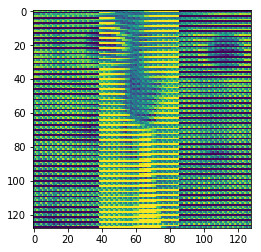

In [49]:
print "Class: ", class_labels[y_train[1]]
imgplot = plt.imshow(X_train[1][0])

# ConvNet Architecture and Training

Now we can define our ConvNet architecture and then train it using a GPU/CPU (I have a very cheap GPU, but it helps a lot):

In [4]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 28, 28),
    # layer conv2d1
    conv2d1_num_filters=32,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=10,
    verbose=1,
    )
# Train the network
nn = net1.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 160362 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x28x28
  1  conv2d1   32x24x24
  2  maxpool1  32x12x12
  3  conv2d2   32x8x8
  4  maxpool2  32x4x4
  5  dropout1  32x4x4
  6  dense     256
  7  dropout2  256
  8  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.79075     0.16763    4.71711      0.95202  12.33s
      2     0.26027     0.10457    2.48895      0.96972  12.33s
      3     0.18978     0.08611    2.20403      0.97511  12.32s
      4     0.15696     0.07334    2.14029      0.97901  12.24s
      5     0.13425     0.06649    2.01916      0.98051  12.35s
      6     0.12061     0.05892    2.04700      0.98221  12.46s
      7     0.10684     0.05647    1.89195      0.98321  12.47s
      8     0.09841     0.05493    1.79164      0.98371  12.38s
      9     0.09611     0.04960    1.93777      0.98

# Prediction and Confusion Matrix

Now we can use the model to predict the entire testing dataset:



In [5]:
preds = net1.predict(X_test)

And we can also plot a confusion matrix to check the performance of the neural network classification:

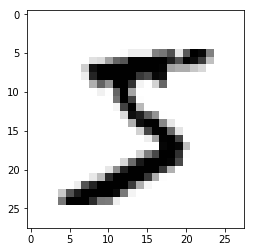

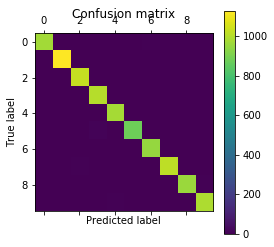

In [6]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Filters Visualization

We can also visualize the 32 filters from the first convolutional layer:

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

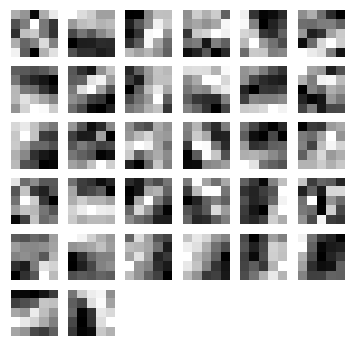

In [14]:
visualize.plot_conv_weights(net1.layers_['conv2d1'])

# Theano layer functions and Feature Extraction

Now it is time to create theano-compiled functions that will feed-forward the input data into the architecture up to the layer you’re interested. I’m going to get the functions for the output layer and also for the dense layer before the output layer:

In [8]:
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

As you can see, we have now two theano functions called f_output and f_dense (for the output and dense layers). Please note that in order to get the layers here we are using a extra parameter called “deterministic“, this is to avoid the dropout layers affecting our feed-forward pass.

We can now convert an example instance to the input format and then feed it into the theano function for the output layer:

In [9]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)

500 loops, best of 3: 3.68 ms per loop


We can also plot the output layer activations for the instance:

<Container object of 10 artists>

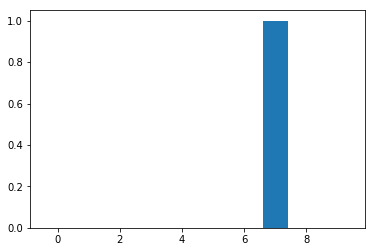

In [15]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

As you can see, the digit was recognized as the digit 7. The fact that you can create theano functions for any layer of the network is very useful because you can create a function (like we did before) to get the activations for the dense layer (the one before the output layer) and you can use these activations as features and use your neural network not as classifier but as a feature extractor. Let’s plot now the 256 unit activations for the dense layer:

<Container object of 256 artists>

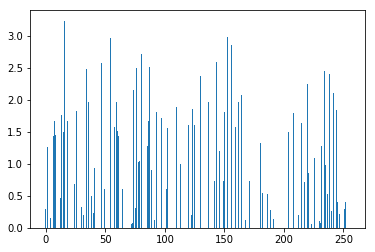

In [16]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

You can now use the output of the these 256 activations as features on a linear classifier like Logistic Regression or SVM.